In [232]:
from library.BPMNGraphEmbedder import BPMNGraphEmbedder
from library.BPMNGraph import BPMNGraph
from tqdm import tqdm
import os

graphEmbedder = BPMNGraphEmbedder()


folders = [
    "..\\data\\camunda\\German\\01-Vorbereitung-des-Warenversands\\02-Ergebnisse\\",
    "..\\data\\camunda\\German\\02-Regressnahme\\02-Ergebnisse\\",
    "..\\data\\camunda\\German\\03-Schufascoring\\02-Ergebnisse\\",
    "..\\data\\camunda\\German\\04-Selbstbedienungsrestaurant\\02-Ergebnisse\\",
    "..\\data\\camunda\\English\\01-Dispatch-of-goods\\02-Results\\",
    "..\\data\\camunda\\English\\02-Recourse\\02-Results\\",
    "..\\data\\camunda\\English\\03-Credit-scoring\\02-Results\\",
    "..\\data\\camunda\\English\\04-Self-service-restaurant\\02-Results\\",
    
  
]

classes_index = {
    "01-Dispatch-of-goods": 0,
    "01-Vorbereitung-des-Warenversands":0,
    "02-Recourse": 1,
    "02-Regressnahme": 1,
    "03-Credit-scoring": 2,
    "03-Schufascoring": 2,
    "04-Self-service-restaurant": 3,
    "04-Selbstbedienungsrestaurant": 3
}

inverse_classes_index = {v: k for k, v in classes_index.items() if k.endswith('goods') or k.endswith('Recourse') or k.endswith('Credit-scoring') or k.endswith('Self-service-restaurant')}

all_bpmns = {}
for folder in folders:
    # Get a list of all BPMN files in the folder
    all_files = os.listdir(folder)

    # Process first 100 BPMN files in the folder
    for bpmn_file in tqdm(all_files[:100]):
        bpmn_graph = BPMNGraph(folder + bpmn_file)
        bpmn_graph.get_graph()["class"] = classes_index[folder.split("\\")[-3]]
        graphEmbedder.process_graph(bpmn_graph.network, logging=False)
        all_bpmns[folder + bpmn_file] = bpmn_graph


100%|██████████| 49/49 [02:07<00:00,  2.60s/it]


# Testing of MED (Minimal edit distance) and creation of samples

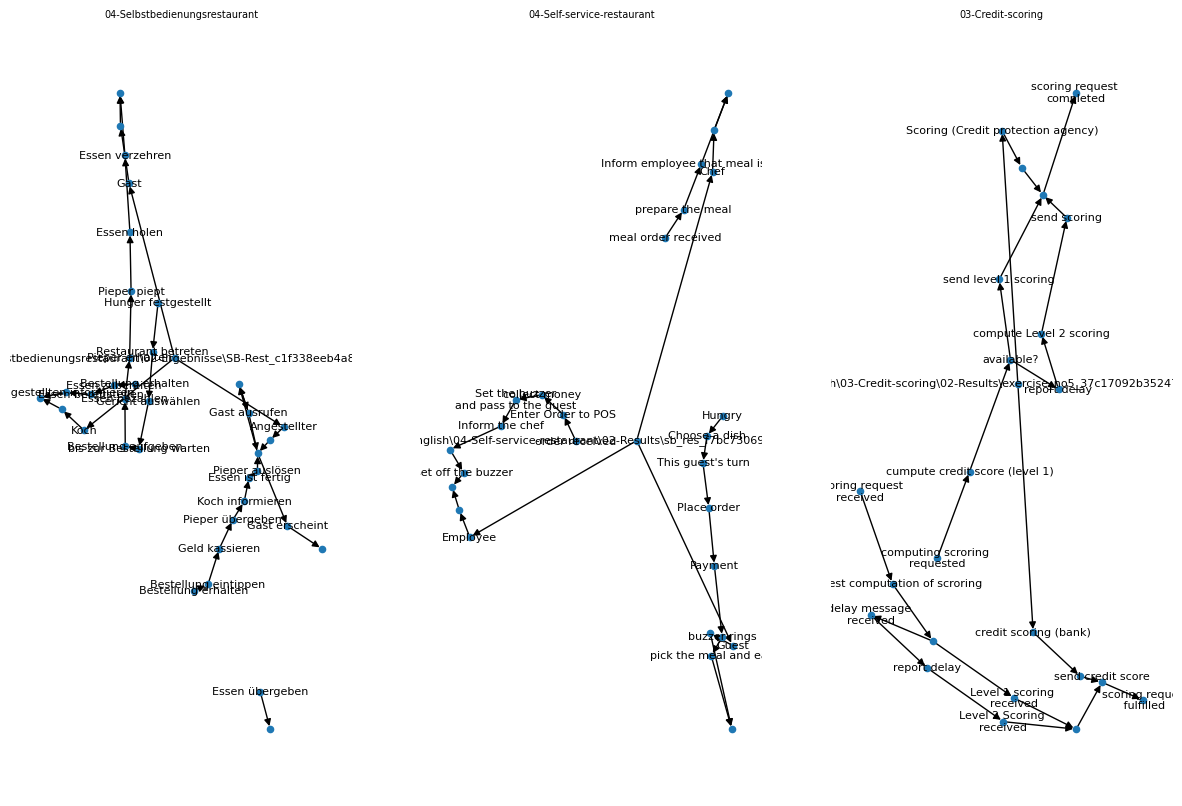

In [184]:
# Select 3 random BPMN files
import random
import numpy as np


def select_and_display_bpmns(all_bpmns, with_labels=True):
    # Group the BPMNs by class
    bpmns_by_class = {}
    for bpmn_id, bpmn in all_bpmns.items():
        class_ = bpmn.get_graph()["class"]
        if class_ not in bpmns_by_class:
            bpmns_by_class[class_] = []
        bpmns_by_class[class_].append(bpmn_id)

    # Select a random class
    random_class = random.choice(list(bpmns_by_class.keys()))

    # Select two random BPMNs from the same random class
    random_files_same_class = random.sample(bpmns_by_class[random_class], 2)

    # Select a different class
    different_class = random.choice([class_ for class_ in bpmns_by_class.keys() if class_ != random_class])

    # Select a random BPMN from a different class
    random_file_different_class = random.choice(bpmns_by_class[different_class])

    # Combine the selected BPMNs
    selected_bpmns = random_files_same_class + [random_file_different_class]
    selected_bpmns_graphs = [all_bpmns[bpmn_id] for bpmn_id in selected_bpmns]
    # Draw the graphs
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    for i, bpmn_id in enumerate(selected_bpmns):
        bpmn_graph = all_bpmns[bpmn_id]
        if not with_labels:
            labels = {node: data.get("name", "") for node, data in bpmn_graph.network.nodes(data=True)}
            nx.draw(bpmn_graph.network, ax=axs[i], with_labels=False, node_size=20, font_size=8)
        else:
            labels = {node: data.get("name", "") for node, data in bpmn_graph.network.nodes(data=True)}
            nx.draw(bpmn_graph.network, ax=axs[i], with_labels=True, labels=labels, node_size=20, font_size=8)
        axs[i].set_title(bpmn_id.split("\\")[-3], fontsize=7)

    plt.show()

    return selected_bpmns_graphs


selected_bpmns = select_and_display_bpmns(all_bpmns, with_labels=True)

In [189]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def count_identical_nodes(G1, G2, threshold = 0.7):
    count_sim_matches = 0
    count_type_matches = 0
    matched_nodes_G2 = set()  # Keep track of the nodes in G2 that have already been matched

    for node1, data1 in G1.nodes(data=True):
        for node2, data2 in G2.nodes(data=True):
            if node2 in matched_nodes_G2:
                continue  # Skip this node if it has already been matched

            # If both nodes have an embedding, compare the embeddings using cosine similarity
            if 'embedding' in data1 and 'embedding' in data2:
                embedding1 = np.array(data1['embedding']).reshape(1, -1)
                embedding2 = np.array(data2['embedding']).reshape(1, -1)
                similarity = cosine_similarity(embedding1, embedding2)
                if similarity >= threshold:
                    count_sim_matches += 1
                    matched_nodes_G2.add(node2)  # Mark this node as matched
                    break

            # If both nodes have a type, compare the types
            elif 'type' in data1 and 'type' in data2:
                if data1['type'] == data2['type']:
                    count_type_matches += 1
                    matched_nodes_G2.add(node2)  # Mark this node as matched
                    break

    return count_sim_matches, count_type_matches

G1 = selected_bpmns[0].network
G2 = selected_bpmns[1].network
G3 = selected_bpmns[2].network

# Print the number of nodes in each graph
print(f"Number of nodes in G1: {len(G1.nodes)}")
print(f"Number of nodes in G2: {len(G2.nodes)}")
print(f"Number of nodes in G3: {len(G3.nodes)}")

# Count the number of identical nodes between the graphs with a threshold of 0.7
threshold = 0.7
count_sim_G1_G2, count_type_G1_G2 = count_identical_nodes(G1, G2, threshold)
count_sim_G1_G3, count_type_G1_G3 = count_identical_nodes(G1, G3, threshold)
count_sim_G2_G3, count_type_G2_G3 = count_identical_nodes(G2, G3, threshold)

# Print the counts for each comparison
print(f"The number of identical nodes between G1 and G2 based on similarity is {count_sim_G1_G2} and based on type is {count_type_G1_G2}. Total number of identical nodes is {count_sim_G1_G2 + count_type_G1_G2}")
print(f"The number of identical nodes between G1 and G3 based on similarity is {count_sim_G1_G3} and based on type is {count_type_G1_G3}. Total number of identical nodes is {count_sim_G1_G3 + count_type_G1_G3}")
print(f"The number of identical nodes between G2 and G3 based on similarity is {count_sim_G2_G3} and based on type is {count_type_G2_G3}. Total number of identical nodes is {count_sim_G2_G3 + count_type_G2_G3}")

Number of nodes in G1: 37
Number of nodes in G2: 27
Number of nodes in G3: 24
The number of identical nodes between G1 and G2 based on similarity is 18 and based on type is 0. Total number of identical nodes is 18
The number of identical nodes between G1 and G3 based on similarity is 5 and based on type is 0. Total number of identical nodes is 5
The number of identical nodes between G2 and G3 based on similarity is 5 and based on type is 0. Total number of identical nodes is 5


In [196]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def node_substitution_cost(node1, node2, threshold=0.6):
    # Check if both nodes have an 'embedding' attribute
    if 'embedding' in node1 and 'embedding' in node2:
        # Compute the cosine similarity between the embeddings
        embedding1 = np.array(node1['embedding']).reshape(1, -1)
        embedding2 = np.array(node2['embedding']).reshape(1, -1)
        similarity = cosine_similarity(embedding1, embedding2)[0][0]
        # Return True if the similarity is above the threshold
        return 0 if similarity >= threshold else 10
    # If both nodes do not have an 'embedding' attribute but have the same 'type', it is a match
    elif 'embedding' not in node1 and 'embedding' not in node2 and node1.get('type') == node2.get('type'):
        return 0
    # In all other cases, it is not a match
    else:
        return 10
def node_insertion_cost(node):
    return 10
def node_deletion_cost(node):
    return 10


def edge_substitution_cost(edge1, edge2):
    if edge1.get('type') == edge2.get('type'):
        return 0
    else:
        return 2
def edge_insertion_cost(edge):
    return 2
def edge_deletion_cost(edge):
    return 2

# Compute the minimum edit distance between each pair of graphs
names = ['G1', 'G2', 'G3']

for i in range(len(selected_bpmns)):
    for j in range(i+1, len(selected_bpmns)):
        distance = nx.optimize_graph_edit_distance(selected_bpmns[i].network, selected_bpmns[j].network, 
                                                    node_subst_cost=node_substitution_cost,
                                                    node_ins_cost=node_insertion_cost,
                                                    node_del_cost=node_deletion_cost,
                                                    edge_subst_cost=edge_substitution_cost,
                                                    edge_ins_cost=edge_insertion_cost,
                                                    edge_del_cost=edge_deletion_cost)
        edit_distance = next(distance)
        total_nodes = len(selected_bpmns[i].network.nodes) + len(selected_bpmns[j].network.nodes)
        normalized_distance = edit_distance / total_nodes
        print("\n-------------------")
        print(f"The minimum edit distance between {names[i]} and {names[j]} is {edit_distance} ({1.0 - edit_distance/500.0})")
        print(f"The normalized minimum edit distance between {names[i]} and {names[j]} is {normalized_distance} ({1.0 - normalized_distance/10})")


-------------------
The minimum edit distance between G1 and G2 is 276.0 (0.44799999999999995)
The normalized minimum edit distance between G1 and G2 is 4.3125 (0.56875)

-------------------
The minimum edit distance between G1 and G3 is 424.0 (0.15200000000000002)
The normalized minimum edit distance between G1 and G3 is 6.950819672131147 (0.30491803278688523)

-------------------
The minimum edit distance between G2 and G3 is 296.0 (0.40800000000000003)
The normalized minimum edit distance between G2 and G3 is 5.803921568627451 (0.41960784313725497)


In [236]:
def compute_distances(bpmns, n=10):
    # Initialize an empty list to store the results
    results = []

    # Initialize variables to store the maximum distance and maximum normalized distance
    max_distance = 0
    max_normalized_distance = 0

    # Initialize a set to store the pairs that have already been encountered
    encountered_pairs = set()

    # Compute the minimum edit distance between each BPMN and n random BPMNs in class 0
    for bpmn_id, bpmn in tqdm(bpmns.items(), desc="Processing BPMNs"):
        for _ in range(n):
            other_id, other_bpmn = random.choice(list(bpmns.items()))

            # Create a tuple that represents the pair
            pair = (bpmn_id, other_id) if bpmn_id < other_id else (other_id, bpmn_id)

            # If the pair has already been encountered, skip this iteration
            if pair in encountered_pairs:
                continue

            # Add the pair to the set of encountered pairs
            encountered_pairs.add(pair)

            distance = nx.optimize_graph_edit_distance(bpmn.network, other_bpmn.network,
                                                        node_subst_cost=node_substitution_cost,
                                                        node_ins_cost=node_insertion_cost,
                                                        node_del_cost=node_deletion_cost,
                                                        edge_subst_cost=edge_substitution_cost,
                                                        edge_ins_cost=edge_insertion_cost,
                                                        edge_del_cost=edge_deletion_cost)
            distance = next(distance)
            # Compute the normalized distance
            total_nodes = len(bpmn.network.nodes) + len(other_bpmn.network.nodes)
            normalized_distance = distance / total_nodes
            # Store the result
            results.append((bpmn.file_path, other_bpmn.file_path, distance, normalized_distance))
            # Update the maximum distance and maximum normalized distance
            max_distance = max(max_distance, distance)
            max_normalized_distance = max(max_normalized_distance, normalized_distance)
            
    # Statistics
    print(f"Number of BPMNs: {len(bpmns)}")
    print(f"Number of comparisons: {len(results)}")
    print(f"\nStatistics for distances:")
    print(f"Minimum distance: {min([distance for _, _, distance, _ in results])}")
    print(f"Maximum distance: {max_distance}")
    print(f"Average distance: {sum([distance for _, _, distance, _ in results]) / len(results)}")
    print(f"\nStatistics for normalized distances:")
    print(f"Minimum normalized distance: {min([normalized_distance for _, _, _, normalized_distance in results])}")
    print(f"Maximum normalized distance: {max_normalized_distance}")
    print(f"Average normalized distance: {sum([normalized_distance for _, _, _, normalized_distance in results]) / len(results)}")

    # Rescale the distances and normalized distances to be within the range of 0 to 1
    results = [(bpmn_id1, bpmn_id2, distance, normalized_distance) for bpmn_id1, bpmn_id2, distance, normalized_distance in results]
    
    # Create json object for the results
    json_results = []
    for bpmn_id1, bpmn_id2, distance, normalized_distance in results:
        json_results.append({
            "source_bpmn_id": bpmn_id1,
            "source_class": inverse_classes_index[bpmns[bpmn_id1].get_graph()["class"]],
            "target_bpmn_id": bpmn_id2,
            "target_class": inverse_classes_index[bpmns[bpmn_id2].get_graph()["class"]],
            "edit_distance": distance,
            "scaled_edit_distance": distance / max_distance,
            "normalized_edit_distance": normalized_distance,
            "scaled_normalized_edit_distance": normalized_distance / max_normalized_distance
        })
        
    # Sort the results based on the distance score
    sorted_results = sorted(results, key=lambda x: x[3], reverse=True)

    return sorted_results, json_results

sorted_results, json_results = compute_distances(all_bpmns, n=100)

# Save the results to a json file
import json

with open("camunda_edit_distance_dataset_01.json", "w") as f:
    for result in json_results:
        f.write(json.dumps(result) + "\n")


Processing BPMNs: 100%|██████████| 597/597 [7:00:13<00:00, 42.23s/it]      


Number of BPMNs: 597
Number of comparisons: 50688

Statistics for distances:
Minimum distance: 0.0
Maximum distance: 562.0
Average distance: 276.3052793560606

Statistics for normalized distances:
Minimum normalized distance: 0.0
Maximum normalized distance: 11.736842105263158
Average normalized distance: 4.996998573689698


In [226]:
def display_sample(sample):
    # Unpack the sample
    bpmn_id1, bpmn_id2, score, norm_score = sample

    #Logging
    print(f"file name: {bpmn_id1}")
    print(f"file name: {bpmn_id2}")
    print(f"Score: {score}", f"Normalized Score: {norm_score}")


    # Retrieve the BPMN graphs
    bpmn_graph1 = all_bpmns[bpmn_id1]
    bpmn_graph2 = all_bpmns[bpmn_id2]

    # Draw the graphs
    fig, axs = plt.subplots(1, 2, figsize=(10, 15))

    # Get labels for the nodes
    labels1 = {node: data.get("name", "") for node, data in bpmn_graph1.network.nodes(data=True)}
    labels2 = {node: data.get("name", "") for node, data in bpmn_graph2.network.nodes(data=True)}

    # Get positions for the nodes
    pos1 = nx.spring_layout(bpmn_graph1.network)
    pos2 = nx.spring_layout(bpmn_graph2.network)

    # Draw the graphs with labels
    nx.draw(bpmn_graph1.network, pos=pos1, ax=axs[0], with_labels=True, labels=labels1, node_size=20, font_size=8)
    axs[0].set_title(bpmn_id1, fontsize=7)
    nx.draw(bpmn_graph2.network, pos=pos2, ax=axs[1], with_labels=True, labels=labels2, node_size=20, font_size=8)
    axs[1].set_title(bpmn_id2, fontsize=7)

    plt.show()


def print_samples(samples):
    for i, sample in enumerate(samples):
        print(f"\n------------Sample {i+1}:")
        # Unpack the sample
        bpmn_id1, bpmn_id2, score, norm_score = sample

        #Logging
        print(f"file name: {bpmn_id1}")
        print(f"file name: {bpmn_id2}")
        print(f"Score: {score}", f"Normalized Score: {norm_score}")


In [228]:
sorted_results, samples = compute_distances(all_bpmns, n=1)

Processing BPMNs: 100%|██████████| 380/380 [01:08<00:00,  5.57it/s]

Number of BPMNs: 380
Number of comparisons: 377

Statistics for distances:
Minimum distance: 64.0
Maximum distance: 502.0
Average distance: 292.106100795756

Statistics for normalized distances:
Minimum normalized distance: 1.3617021276595744
Maximum normalized distance: 11.071428571428571
Average normalized distance: 5.193981729170195
